# Computational Photography - High Dynamic Range Image Fusion

---
## 0) Importing Libraries and File Configuration/Reader

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np

# data file directory
# link: 


# 7708.6-11
# roi origin: (33, 26)
# roi width: 334
# roi height: 216

fdir = './7708.6-11/'
x, y = 33, 26
width, height = 334, 216

# 7708.24-29
# roi origin: (21, 46)
# roi width: 215
# roi height: 327

# fdir = './7708.24-29/'
# x, y = 21, 46
# width, height = 215, 327

# 7710.1-6
# roi origin: (31, 33)
# roi width: 216
# roi height: 328

# fdir = './7710.1-6/'
# x, y = 31, 33
# width, height = 216, 328

In [225]:
calparam = pd.read_csv(fdir + 'calparam', delimiter='\t')
imgpath = []
with open(fdir + 'imglist', 'r') as f:
    for l in f:
        tokens = l.split('\t')
        if tokens[0] == 'FileName':
            imgpath.append(fdir + tokens[-1].strip())
calparam

,id,calparam,RRCalibrateParamData
0,creator,nobody,NaN
1,numSource,0,NaN
2,maxOrder,5,NaN
3,numExposureRatios,4,NaN
4,exposureRatio,0,0.50
5,exposureRatio,1,0.25
6,exposureRatio,2,0.50
7,exposureRatio,3,0.50
8,convergenceLevel,1.0e-003,NaN


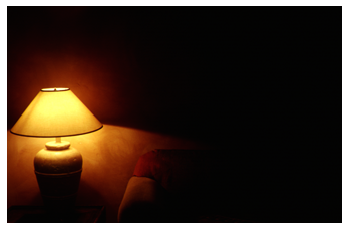

In [226]:
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in imgpath]
plt.imshow(images[0][y:y+height, x:x+width,:])
plt.axis("off")
plt.show()

In [229]:
# over-exposed value and under-exposed value
limit_min = (2 ** 3 - 1) / (2 ** 8 - 1) 
limit_max = 1 - limit_min
print(f"overexposed pixel value: {limit_max}")
print(f"underexposed pixel value: {limit_min}")

exposures = [1]
exposureRatios = list(calparam[calparam['id']=='exposureRatio']['RRCalibrateParamData'])
for ratio in exposureRatios:
    exposures.append(exposures[-1] / ratio)
    
print(f"list of exposures are: \n {exposures}")

overexposed pixel value: 0.9725490196078431
underexposed pixel value: 0.027450980392156862
list of exposures are: 
 [1, 2.0, 8.0, 16.0, 32.0]


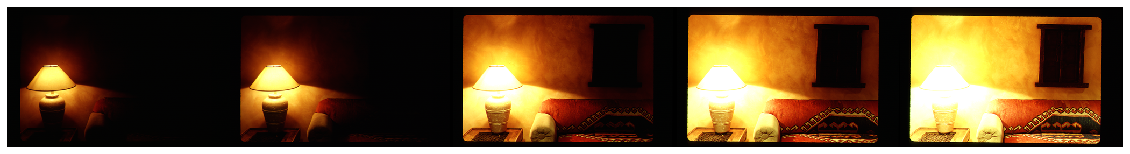

In [141]:
stitched_img = np.concatenate(images, axis=1)
plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(stitched_img)
plt.savefig(fdir+"stitch.png", dpi=200)
plt.show()

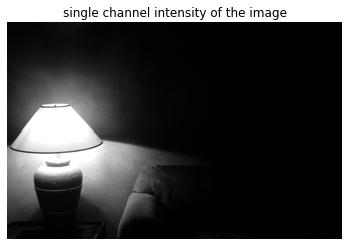

In [228]:
# picture after normalization
plt.imshow(images[0][y:y+height, x:x+width, ch_index]/255, cmap='gray')
plt.title("single channel intensity of the image")
plt.axis("off")
plt.show()

## 1) Develop Polynomial Function Evaluation

- Develop a function/method named ```evalPoly``` that evaluates a polynomial at a given point. The function must handle an arbitrary number of polynomial coefficients (in either ascending or descending order). 

- Develop a function/method named ```polyDerivative``` that calculates the derivative of a polynomial. The input is n polynomial coefficients (in either ascending or descending order) and the output is the **n − 1** polynomial coefficients (in either ascending or descending order) of the derivative of the input polynomial.

In [143]:
def evalPoly(x, coeff):
    # suppose the coeff at 0's term is 0, coeff: n x 1
    n = np.max(coeff.shape)
    coeff = coeff.reshape(n, -1)
    x_aug = np.array([x ** i for i in range(1, n+1)])
    assert x_aug.shape[0] == n
    if len(x_aug.shape) == 1:
        x_aug = x_aug.reshape(-1, 1).T
    elif len(x_aug.shape) == 2:
        x_aug = x_aug.T
    elif len(x_aug.shape) == 3:
        # x_aug: coeff_degree x img_height x img_width
        x_aug = x_aug.reshape(n, -1).T
    elif len(x_aug.shape) == 4:
        # x_aug: coeff_degree x num_images x img_height x img_width 
        m = np.min(x_aug.shape) # assume number of images is the smallest dimension
        x_aug = np.transpose(x_aug, (1, 0, 2, 3))
        x_aug = np.transpose(x_aug.reshape(m, n, -1), (0, 2, 1))
        coeff = coeff[np.newaxis, ...]
    return (x_aug @ coeff).reshape(x.shape)

def polyDerivative(x, coeff):
    n = np.max(coeff.shape)
    coeff_derivatives = np.array([coeff.flatten()[i-1] * i for i in range(1, n+1)])
    coeff_derivatives = coeff_derivatives.reshape(-1,1)
    x_aug = np.array([x ** (i-1) for i in range(1, n+1)])
    assert x_aug.shape[0] == n
    if len(x_aug.shape) == 1:
        x_aug = x_aug.reshape(-1, 1).T
    elif len(x_aug.shape) == 2:
        x_aug = x_aug.T
    elif len(x_aug.shape) == 3:
        # x_aug: coeff_degree x img_height x img_width
        x_aug = x_aug.reshape(n, -1).T
    elif len(x_aug.shape) == 4:
        # x_aug: coeff_degree x num_images x img_height x img_width 
        m = np.min(x_aug.shape) # assume number of images is the smallest dimension
        x_aug = np.transpose(x_aug, (1, 0, 2, 3))
        x_aug = np.transpose(x_aug.reshape(m, n, -1), (0, 2, 1))
        coeff_derivatives = coeff_derivatives[np.newaxis, ...]
    return (x_aug @ coeff_derivatives).reshape(x.shape)

## 2) Estimate Inverse Camera Response Function

Develop a function/method named estimateCameraResponseInv that estimates the inverse of the camera response function given a set of nonlinear color encoded **8 or 16 bit unsigned integer per sample** images and associated exposures (e.g., shutter times in seconds). The inverse of the camera response function maps the images from the nonlinear color encoding to a linear color space and must be modeled as a polynomial, where the function determines the number of coefficients (from 3 up to a specified maximum number) resulting in the minimum (sum of absolute) error.


The function/method must only utilize pixels within the range of specified minimum and maximum correctly exposed pixel values to estimate the polynomial coefficients (in either ascending or descending order). Further, the function/method must scale polynomial coefficients of channels to preserve chromaticity. (Hint: use evalPoly when computing the error and estimating the scales of the polynomial coefficients
of channels.) Download **7708.6-11.zip** from https://www.cs.columbia.edu/CAVE/software/rascal/rrslrr.php and use estimateCameraResponseInv to estimate the inverse camera response function from the data set. In your report, include a plot of inverse camera response function for each channel (on a single plot).

In [205]:
"""
This function takes a vector x of arbitrary shape, and the degree of polynomial
returns the [x^1, x^2, ..., x^(n-1)] and x^n, where x^n has the same shape as original vector x
:param: x, the original vector for polynomial augmentation
:param: n, the degree of polynomial function
"""
def polyStack(x, n):
    # v_x = [x^1, x^2, ..., x^N-1]
    v_x = np.array([x ** i for i in range(1, n)])
    # yi = x^N
    x_N = np.array([x ** n])
    return v_x, x_N

def solvePolyStack(e1, x1, e2, x2, n):
    # n-2 x img_dim, 1 x img_dim
    index = np.logical_and.reduce([x1 > limit_min, x1 < limit_max, x2 > limit_min, x2 < limit_max])
    v1, x1_N = polyStack(x1, n)
    v2, x2_N = polyStack(x2, n)
    l = ((v1 - x1_N) / e1 - (v2 - x2_N) / e2)[:, index] # n-1 x img_dim
    r = (x2_N / e2 - x1_N / e1).reshape(1,-1)[:, index] # 1 x img_dim
    assert r.shape[0] == 1 and l.shape[0] == n-1
    return l @ l.T, l @ r.T

def solveCameraResponseCoeff(single_channel_imgs, exposures, n):
    aat = np.zeros((n-1, n-1))
    ab = np.zeros((n-1,1))
    for i in range(len(exposures)-1):
        for j in range(i+1, len(exposures)):
            # print(f"calculating exposure {i}: {exposures[i]}, with exposure {j}: {exposures[j]}")
            llt, lrt = solvePolyStack(exposures[i], single_channel_imgs[i], exposures[j], single_channel_imgs[j], n)
            aat += llt
            ab += lrt
    coeff = np.linalg.inv(aat) @ ab
    coeff = np.vstack([coeff, 1-coeff.sum()])
    assert np.max(coeff.shape) == n
    # print("calculating the polynomial function fitting error")
    cost = 0
    for i in range(len(exposures)-1):
        for j in range(i+1, len(exposures)):
            cost += polyError(exposures[i], single_channel_imgs[i], exposures[j], single_channel_imgs[j], coeff)
    return coeff, cost

def polyError(e1, x1, e2, x2, coeff):
    index = np.logical_and.reduce([x1 > limit_min, x1 < limit_max, x2 > limit_min, x2 < limit_max])
    cost = np.square(evalPoly(x1[index], coeff) / e1 - evalPoly(x2[index], coeff) / e2)
    return np.sum(cost)

In [234]:
n = 5
channels = [0, 1, 2] # perform on all RGB channels
coeff_channels = []
total_cost = 0
for c in range(3):
    s_channel_imgs = [(images[i][y:y+height, x:x+width, c] / 255).flatten() for i in range(len(images))]
    coeff, cost = solveCameraResponseCoeff(s_channel_imgs, exposures, n)
    coeff_channels.append(coeff)
    total_cost += cost
print(f"polynomial degree {n} with error: {total_cost}")

polynomial degree 5 with error: 34.149403014125284


In [235]:
coeff_channels[0] # red

array([[  1.12222509],
       [ -6.10673631],
       [ 18.66899571],
       [-23.96065404],
       [ 11.27616954]])

In [236]:
coeff_channels[1] # green

array([[  1.31977486],
       [ -8.21569856],
       [ 26.20264347],
       [-34.79303014],
       [ 16.48631037]])

In [237]:
coeff_channels[2] # blue

array([[  0.65054992],
       [ -4.41681284],
       [ 15.86411261],
       [-23.33425582],
       [ 12.23640613]])

In [238]:
def color_correction_scale(x1, y1):
    m = x1.shape[1]
    # x1: 3 x img_dim, y1: 3 x img_dim
    x_norm = np.linalg.norm(x1, axis=0).reshape(-1, 1, 1) # img_dim x 1 x 1
    x1, y1 = x1.T.reshape(-1, 3, 1), y1.T.reshape(-1, 3, 1) # img_dim x 3 x 1, img_dim x 3 x 1
    x_diag = (-x_norm ** 2 * y1 * y1) # img_dim x 3 x 1
    assert x_diag.shape[0] == m
    diag_vec = np.zeros((m, 3, 3))
    diag_vec[:, 0, 0] = x_diag[:, 0, 0]
    diag_vec[:, 1, 1] = x_diag[:, 1, 0]
    diag_vec[:, 2, 2] = x_diag[:, 2, 0]
    M = diag_vec + ((x1 ** 2) @ np.transpose(y1 ** 2, (0, 2, 1)))
    M = np.transpose(M, (0, 2, 1)) @ M
    return M.sum(axis=0)

def calcColorScale(images, coeff_channels, n):
    M = np.zeros((3,3))
    for img in images:
        nRGB = img.reshape(-1, 3)/255.0
        index = np.logical_and(nRGB > limit_min, nRGB < limit_max)
        nRGB_x = nRGB[index.sum(axis=1) == 3, :] # img_dim x 3
        irrad_y = np.zeros(nRGB_x.shape)
        for i in range(3):
            a, b = polyStack(nRGB_x[:, i], n)
            a = np.vstack([a, b])
            irrad_y[:, i] = (a.T @ coeff_channels[i]).flatten()
        M += color_correction_scale(nRGB_x.T, irrad_y.T)
    U, D, Vt = np.linalg.svd(M)
    k = np.sqrt(Vt[-1, :])
    k = k / k.max()
    return k

In [239]:
k = calcColorScale(images, coeff_channels, n)

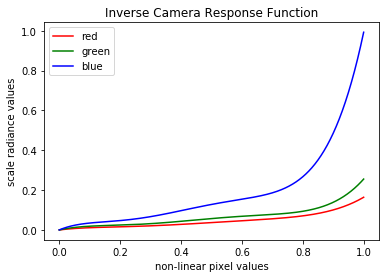

In [240]:
data = np.arange(0, 1, 1/1000)
for i, c in enumerate(["red", "green", "blue"]):
    x_data, x_N = polyStack(data, n)
    x_data = np.vstack([x_data, x_N])
    coeff = coeff_channels[i]
    y_data = k[i] * x_data.T @ coeff
    plt.plot(data, y_data, label=c, color=c)
plt.title("Inverse Camera Response Function")
plt.legend()
plt.xlabel("non-linear pixel values")
plt.ylabel("scale radiance values")
plt.savefig(fdir + 'scaled_inv_camera_response_function.png')
plt.show()

# Calculate HDR Image

Develop a function/method named ```calcHDR``` that converts a set of nonlinear
color encoded **8 or 16 bit unsigned integer per sample** images and associated exposures
to a (linear) **32 bit floating-point per sample** high dynamic range image, given the
inverse of the camera response function (hint: use ```evalPoly``` and ```polyDerivative```).
The function/method must only utilize pixels within the range of specified minimum
and maximum correctly exposed pixel values to compute the high dynamic range image.
If a pixel is underexposed over all exposures, then it must be set to the minimum
properly exposed high dynamic range pixel value in the high dynamic range image.
If a pixel is overexposed over all exposures, then it is set to the maximum properly
exposed high dynamic range pixel value in the high dynamic range image. Otherwise,
if a pixel is not properly exposed in at least one low dynamic range image, then it is set
to the minimum properly exposed high dynamic range pixel value in the high dynamic
range image. Create a high dynamic range image from the data set **7708.6-11.zip**
and write the 32 bit floating-point per sample high dynamic range image to the file
**7708.6-11_32f.exr**. Convert the image to a 16 bit floating-point per sample high
dynamic range image and write it to the file **7708.6-11_16f.exr**. Using ```linearTosRGB```
from assignment 2, convert the 32 bit floating-point per sample high dynamic range
image to a nonlinear sRGB color encoded 8 bit unsigned integer per sample image and
write the resulting image to **7708.6-11.png**.

In [241]:
def linear2sRGB(x):
    x = np.clip(x, 0, 1)
    thres = 0.0031308
    if x <= thres:
        return 12.92 * x
    else:
        return 1.055 * x ** (1/2.4) - 0.055
# vectorize into numpy function
linear2sRGB = np.vectorize(linear2sRGB)

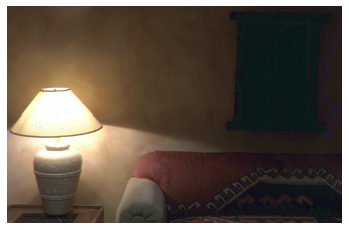

In [242]:
def calcHDR(images, coeffs, scales, exposures):
    
    # preprocessing exposures to make sure the arithmetic mean is 1
    expo = np.array(exposures)
    expo /= expo.mean()
    expo = expo.reshape(-1,1,1)
    
    # preprocessing images
    img = np.stack(images, axis=0)
    # 5 x height x width x 3
    img = img[:, y:y+height, x:x+width, :] / 255
    
    fused_img = np.zeros(img.shape[1:]) # height, width, 3
    
    masks = []
    
    # iterating through all three channels
    for c in range(3):
        # single channel image shape: 5, height, width, 1
        channel_img = img[..., c]
        
        # mix_exposed_mask shape: 5, height, width, 1
        mix_exposed_mask = np.sum(np.logical_or(channel_img > limit_max, channel_img < limit_min), axis=0) == channel_img.shape[0]
        # over_exposed_mask shape: 5, height, width, 1
        over_exposed_mask = np.sum(channel_img > limit_max, axis=0) == channel_img.shape[0]
        # under_exposed_mask shape: 5, height, width, 1
        under_exposed_mask = np.sum(channel_img < limit_min, axis=0) == channel_img.shape[0]
        
        # fill the corner cases with max and minimum value
        fused_img[under_exposed_mask, c] = limit_min / expo.max()
        fused_img[over_exposed_mask, c] = limit_max / expo.min()
        
        # fill the proper exposed
        properly_exposed_mask = np.logical_not(mix_exposed_mask)
        
        # 5 x height x width
        mask = np.logical_and(channel_img < limit_max, channel_img > limit_min)
        
        masks.append(mix_exposed_mask)
        # preprocessing the scale factors
        cs = scales[c] * coeffs[c]

        fx = evalPoly(channel_img, cs)
        fxp = polyDerivative(channel_img, cs)

        wx = np.zeros(fx.shape) + 1e-12
        wx[mask] = fx[mask] / fxp[mask]
        
        fx_ex = fx / expo
        assert fx_ex.shape == wx.shape

        z = np.sum(wx * fx_ex, axis=0) / np.sum(wx, axis=0)
        
        fused_img[properly_exposed_mask, c] = z[properly_exposed_mask]
        masks.append(over_exposed_mask)
        
    return fused_img, masks

fused_img, m = calcHDR(images, coeff_channels, k, exposures)
plt.imshow(linear2sRGB(np.clip(fused_img, 0, 1)))

plt.axis("off")
plt.savefig(fdir+"HDR.png", dpi=200)
plt.show()

# Putting All Together

overexposed pixel value: 0.9725490196078431
underexposed pixel value: 0.027450980392156862
polynomial degree 5 with error: 34.149403014125284


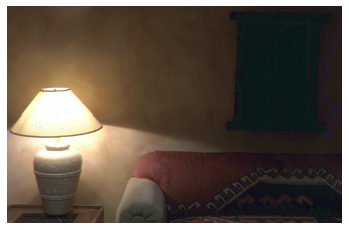

In [233]:
fdir = './7708.6-11/'
x, y = 33, 26
width, height = 334, 216

calparam = pd.read_csv(fdir + 'calparam', delimiter='\t')
imgpath = []
with open(fdir + 'imglist', 'r') as f:
    for l in f:
        tokens = l.split('\t')
        if tokens[0] == 'FileName':
            imgpath.append(fdir + tokens[-1].strip())

images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in imgpath]

# over-exposed value and under-exposed value
limit_min = (2 ** 3 - 1) / (2 ** 8 - 1) 
limit_max = 1 - limit_min
print(f"overexposed pixel value: {limit_max}")
print(f"underexposed pixel value: {limit_min}")

exposures = [1]
exposureRatios = list(calparam[calparam['id']=='exposureRatio']['RRCalibrateParamData'])
for ratio in exposureRatios:
    exposures.append(exposures[-1] / ratio)

# degree of polynomial
n = 5
channels = [0, 1, 2] # perform on all RGB channels
coeff_channels = []
total_cost = 0
for c in range(3):
    s_channel_imgs = [(images[i][y:y+height, x:x+width, c] / 255).flatten() for i in range(len(images))]
    coeff, cost = solveCameraResponseCoeff(s_channel_imgs, exposures, n)
    coeff_channels.append(coeff)
    total_cost += cost
print(f"polynomial degree {n} with error: {total_cost}")

# calculate color correction scales
k = calcColorScale(images, coeff_channels, n)

HDR_img, _ = calcHDR(images, coeff_channels, k, exposures)
plt.imshow(linear2sRGB(np.clip(HDR_img, 0, 1)))
plt.axis("off")
plt.savefig(fdir+"HDR.png", dpi=200)
plt.show()

# Discussion
---

In this section, we will discuss three components which we use to estimate our HDR image:
1. Inverse Camera Response Function: 
    - Degree of Polynomial
    - Handling of Over-exposed and Under-exposed Pixel Samples
2. Scales on Color Correction:
    - Handling Over-exposed and Under-exposed Pixel Samples across channels
3. Calculate High Dynamic Image through Fusion:
    - Handling of abnormal pixels across exposures across images
---
## Degree of Polynomial
When we estimate the inverse camera response function, we first model the function as n-degree polynomial function. Although the estimation can be straight forward, the degree n varies with different camera devices associated with different inverse camera response function. Therefore, when fitting the inverse camera response function with various degrees, our resulting HDR image can be visually changed. From the images demonstrated below, we can see that with polynomial function of degree 5, the resulting HDR image has the best result. However, if we change to a different dataset, we will have different best degree that reflect to the best image. Our function uses ```polyError``` to calculate the best error for which we use to compute the HDR image.

In [217]:
# degree of polynomial
ns = [3,4,5,6,7]
n_images = []
for n in ns:
    channels = [0, 1, 2] # perform on all RGB channels
    coeff_channels = []
    total_cost = 0
    for c in range(3):
        s_channel_imgs = [(images[i][y:y+height, x:x+width, c] / 255).flatten() for i in range(len(images))]
        coeff, cost = solveCameraResponseCoeff(s_channel_imgs, exposures, n)
        coeff_channels.append(coeff)
        total_cost += cost

    # calculate color correction scales
    k = calcColorScale(images, coeff_channels, n)

    HDR_img, _ = calcHDR(images, coeff_channels, k, exposures)
    n_images.append(np.clip(HDR_img, 0, 1))

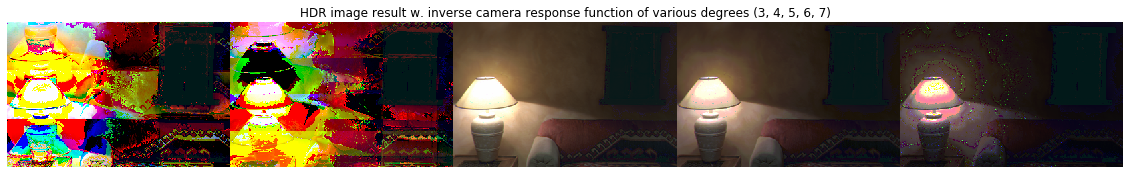

In [216]:
plt.figure(figsize=(20, 5))
plt.title("HDR image result w. inverse camera response function of various degrees (3, 4, 5, 6, 7)")
plt.imshow(linear2sRGB(np.concatenate(n_images, axis=1)))
plt.axis("off")
plt.show()

## Handling Over-exposed and Under-exposed Pixels from the Dataset

Normally, when we have a set of burst images taken with various exposures, it is important to know that some of the pixels might be under-exposed or over-exposed in the images. In the figure below, we have shown the heat map of over-exposed or under-exposed pixels in the burst images. Not surprisingly, the region of light bulb has a high over-exposure rate (bright area), while the right closet has a high under-exposure rate (dark area). It is important to exclude those pixels in calculating the inverse camera response function in addition to the polynomial fitting error.

However, it is highly likely that the pixel at the same location of one image might be over-exposed or under-exposed, while properly exposed in another. This mixture of over-exposed, proper-exposed, under-exposed across the images may further introduce complication during our calculation of HDR image. Therefore, in our ```calcHDR``` function, we analyze four cases to appropriately process different pixels across fusion process:
1. If a pixel is over-exposed across all the images, then we set the value of HDR at the pixel to the highest possible sample value in the HDR value range, which is ```limit_max / expo.min()```
2. If a pixel is under-exposed across images, then we set the value of HDR at the pixel to the lowest possible sample value in the HDR value range, which is ```limit_min / expo.max()```
3. If a pixel is a mixture of over-exposed and under-exposed, we can set the value to arbitrary value, and in our case, this is ```limit_min / expo.max()``` (dark color)
4. If a pixel is properly sampled in at least one image, we only use those properly sampled pixel values to compute the weighted sum across different images

every pixel value under 0.027450980392156862 is under-exposed
every pixel value over 0.9725490196078431 is over-exposed


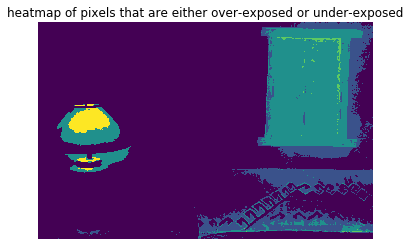

In [224]:
print(f"every pixel value under {limit_min} is under-exposed")
print(f"every pixel value over {limit_max} is over-exposed")
plt.title("heatmap of pixels that are either over-exposed or under-exposed")
plt.imshow(sum(m))
plt.axis("off")
plt.show()